### 衡量预测结果的 BDBR 性能 -> SSIM

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 6)

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.family': 'serif',  # 使用衬线字体
    'font.serif': ['Times New Roman'],  # 指定 Times New Roman 字体
    'font.size': 11,
    'text.usetex': False,
    'axes.labelsize': 11,
    'axes.titlesize': 11,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 9,
    'legend.title_fontsize': 9,
    'savefig.bbox': 'tight',
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'grid.linewidth': 1,
    'axes.linewidth': 1
})
sns.set_style("whitegrid")
flierprops = dict(marker='o', markersize=2, linestyle='none')

table_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/tables"
fig_dir   = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"

In [2]:
def rm_outliers(df, cols, threshold=1.5, lower_only=True):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - (threshold * IQR)
        upper_bound = Q3 + (threshold * IQR)

        if lower_only:
            df = df[df[col] >= lower_bound]
        else:
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df

#### 1. 预测的是 log2ssim

In [3]:
""" 把每个序列所有的 dataframe 叠在一起 """
import os
import re
import pandas as pd
from tqdm import tqdm

seqs = os.listdir(f"{table_dir}/BDBR/rd-log2ssim")
convex_df = pd.DataFrame()

for seq in seqs:
    for f in tqdm(os.listdir(f"{table_dir}/BDBR/rd-log2ssim/{seq}")):
        if not re.search(r"(\d+P)", f):     # 只看一下 cross-preset 的结果
            convex_df = pd.concat([convex_df, pd.read_csv(f"{table_dir}/BDBR/rd-log2ssim/{seq}/{f}")], axis=0)

convex_df = convex_df.reset_index(drop=True) 
display(convex_df)

convex_df.to_csv(f"{table_dir}/BDBR/convex_log2ssim.csv", index=False)

100%|██████████| 983/983 [00:00<00:00, 1012.49it/s]


,seqName,sceneId,regressor,func,input,preset,size,qp,pred_log2ssim,log2ssim,ssim,pred_log2bitrate,log2bitrate,bitrate,pred_bitrate,pred_ssim,convex
0,Lecture-5f3a,0,RandomForestRegressor,quadratic2,faster,slower,1080P,22,-0.012167,-0.006584,0.995447,12.471467,12.639887,6382.4165,5679.181653,0.991602,pred
1,Lecture-5f3a,0,RandomForestRegressor,quadratic2,faster,slower,360P,22,-0.014395,-0.012389,0.991449,9.673069,10.568373,1518.4389,816.364012,0.990072,pred
2,Lecture-5f3a,0,RandomForestRegressor,quadratic2,faster,slower,360P,27,-0.017838,-0.019836,0.986345,9.036935,9.001844,512.6550,525.277025,0.987712,pred
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71585,Lecture-6d29,3,SGDRegressor,quadratic2,faster,medium,360P,27,-0.013040,-0.020464,0.985916,9.632173,9.615933,784.6650,793.547759,0.991002,fixed
71586,Lecture-6d29,3,SGDRegressor,quadratic2,faster,medium,540P,27,-0.010023,-0.015414,0.989373,10.380215,10.374007,1327.0500,1332.772733,0.993076,fixed
71587,Lecture-6d29,3,SGDRegressor,quadratic2,faster,medium,720P,27,-0.009170,-0.012564,0.991329,10.814260,10.824000,1812.7950,1800.597665,0.993664,fixed


In [4]:
""" 计算 BDBR -> 1) 相较于传统 CAE (会有 loss);  2) 相较于 fixed QP (会有 gain) """
from fastCAE.metrics.bjontegaard import BD_PSNR
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 8)

grouped = convex_df.groupby(["seqName", "sceneId", "regressor", "func", "input", "preset"])
rows = []
for i, ((seqName, sceneId, regressor, func, inputs, preset), group) in tqdm(enumerate(grouped)):
    pred_convex_df   = group[group["convex"] == "pred"].sort_values(by="bitrate").reset_index(drop=True)
    actual_convex_df = group[group["convex"] == "actual"].sort_values(by="bitrate").reset_index(drop=True)
    fixed_convex_df  = group[group["convex"] == "fixed"].sort_values(by="bitrate").reset_index(drop=True)
    
    bd_ssim_cae = BD_PSNR(
        actual_convex_df["bitrate"].tolist(), actual_convex_df["ssim"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["ssim"].tolist(), piecewise=0
    )
    bd_ssim_fix = BD_PSNR(
        fixed_convex_df["bitrate"].tolist(), fixed_convex_df["ssim"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["ssim"].tolist(), piecewise=0
    )
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_ssim_cae, "cae"])
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_ssim_fix, "fixed"])
    
all_bdbr = pd.DataFrame(rows, columns=["seqName", "sceneId", "regressor", "func", "input", "preset", "bd_ssim", "anchor"])
all_bdbr = rm_outliers(all_bdbr, cols=["bd_ssim"], threshold=0.75)
display(all_bdbr)
display(all_bdbr.describe())                  

all_bdbr.to_csv(f"{table_dir}/BDBR/all_rd_log2ssim.csv", index=False)

3238it [00:07, 431.20it/s]


,seqName,sceneId,regressor,func,input,preset,bd_ssim,anchor
1,Lecture-42c3,0,Adam,linear,faster,faster,0.001752,fixed
3,Lecture-42c3,0,Adam,linear,faster,medium,0.005847,fixed
5,Lecture-42c3,0,Adam,linear,faster,slower,0.000697,fixed
6,Lecture-42c3,0,Adam,linear,medium,faster,-0.004030,cae
...,...,...,...,...,...,...,...,...
6472,Lecture-7e40,1,SGDRegressor,quadratic2,slower,medium,-0.003452,cae
6473,Lecture-7e40,1,SGDRegressor,quadratic2,slower,medium,0.002928,fixed
6474,Lecture-7e40,1,SGDRegressor,quadratic2,slower,slower,-0.003160,cae
6475,Lecture-7e40,1,SGDRegressor,quadratic2,slower,slower,0.002817,fixed


,sceneId,bd_ssim
count,6031.000000,6031.000000
mean,3.541867,0.000017
std,3.556117,0.003231
min,0.000000,-0.006377
25%,1.000000,-0.002353
50%,2.000000,-0.000247
75%,6.000000,0.001930
max,11.000000,0.045719


In [5]:
# 看一下不同预测策略 (regressor, func, input) 的效果
table_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/tables"
all_bdbr = pd.read_csv(f"{table_dir}/BDBR/all_rd_log2ssim.csv")

grouped = all_bdbr.groupby(["anchor", "regressor", "func", "input"], as_index=False)

rows = []
for (anchor, regressor, func, inputs), group in grouped:
    group = group.reset_index(drop=True)
    rows.append([regressor, func, inputs, group["bd_ssim"].mean(), anchor])

avg_bdbr = pd.DataFrame(rows, columns=["regressor", "func", "input", "bd_ssim", "anchor"])
avg_bdbr = rm_outliers(avg_bdbr, cols=["bd_ssim"], threshold=0.75).reset_index(drop=True)
display(avg_bdbr)

avg_bdbr.to_csv(f"{table_dir}/BDBR/avg_rd_log2ssim.csv", index=False)

,regressor,func,input,bd_ssim,anchor
0,Adam,linear,faster,-0.003297,cae
1,Adam,linear,medium,-0.003062,cae
2,Adam,linear,slower,-0.002791,cae
3,Adam,power,faster,-0.001856,cae
...,...,...,...,...,...
104,SGDRegressor,power,slower,0.002279,fixed
105,SGDRegressor,quadratic2,faster,0.002875,fixed
106,SGDRegressor,quadratic2,medium,0.003006,fixed
107,SGDRegressor,quadratic2,slower,0.002896,fixed


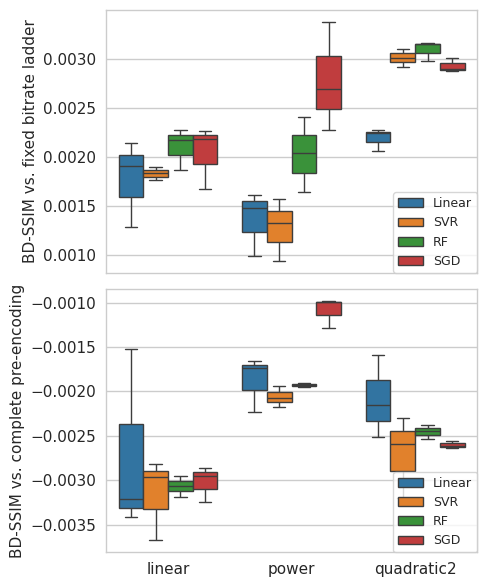

In [6]:
# 直观看一下区别
label_mapping = {
    'Adam': 'Adam',
    'LinearRegression': 'Linear',
    'LinearSVR': 'SVR',
    'RMSProp': 'RMSProp',
    'RandomForestRegressor': 'RF',
    'SGDRegressor': 'SGD'
}

# 画一下 BD-Rate (左边是相比 fixed QP 的, 右边是相比 traditional CAE 的)
fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

sns.boxplot(
    ax=axes[0], data=avg_bdbr[(avg_bdbr["bd_ssim"] < 0.08) & (avg_bdbr["bd_ssim"] > 0) & (avg_bdbr["anchor"] == "fixed") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_ssim", hue="regressor", flierprops=flierprops)
handles, labels = axes[0].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[0].set_xlabel("")
axes[0].set_ylabel("BD-SSIM vs. fixed bitrate ladder")
axes[0].legend(handles, new_labels, borderaxespad=0., loc="lower right")

sns.boxplot(ax=axes[1], data=avg_bdbr[(avg_bdbr["bd_ssim"] < 0) & (avg_bdbr["anchor"] == "cae") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_ssim", hue="regressor", flierprops=flierprops)
handles, labels = axes[1].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[1].set_xlabel("")
axes[1].set_ylabel("BD-SSIM vs. complete pre-encoding")
axes[1].legend(handles, new_labels, borderaxespad=0., loc="lower right")

fig_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"
plt.tight_layout()
plt.savefig(f"{fig_dir}/BDBR/bd_log2ssim.pdf", format="pdf")

#### 2. 预测的是 ssim

In [8]:
""" 把每个序列所有的 dataframe 叠在一起 """
import pandas as pd
from tqdm import tqdm

seqs = os.listdir(f"{table_dir}/BDBR/rd-ssim")
convex_df = pd.DataFrame()

for seq in seqs:
    for f in tqdm(os.listdir(f"{table_dir}/BDBR/rd-ssim/{seq}")):
        if not re.search(r"(\d+P)", f):     # 只看一下 cross-preset 的结果
            convex_df = pd.concat([convex_df, pd.read_csv(f"{table_dir}/BDBR/rd-ssim/{seq}/{f}")], axis=0)

convex_df = convex_df.reset_index(drop=True) 
display(convex_df)

convex_df.to_csv(f"{table_dir}/BDBR/convex_ssim.csv", index=False)

100%|██████████| 1022/1022 [00:00<00:00, 1274.92it/s]


,seqName,sceneId,regressor,func,input,preset,size,qp,pred_ssim,log2ssim,ssim,pred_log2bitrate,log2bitrate,bitrate,pred_bitrate,convex
0,Lecture-5f3a,0,RandomForestRegressor,quadratic2,faster,slower,360P,52,0.967783,-0.045439,0.968995,3.908915,4.393753,21.0209,15.021062,pred
1,Lecture-5f3a,0,RandomForestRegressor,quadratic2,faster,slower,1080P,22,0.991623,-0.006584,0.995447,12.471467,12.639887,6382.4165,5679.181653,pred
2,Lecture-5f3a,0,RandomForestRegressor,quadratic2,faster,slower,360P,22,0.989480,-0.012389,0.991449,9.673069,10.568373,1518.4389,816.364012,pred
3,Lecture-5f3a,0,RandomForestRegressor,quadratic2,faster,slower,360P,27,0.987086,-0.019836,0.986345,9.036935,9.001844,512.6550,525.277025,pred
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74196,Lecture-6d29,3,SGDRegressor,quadratic2,faster,medium,1080P,27,0.994477,-0.009549,0.993403,11.436992,11.465112,2827.1100,2772.538153,fixed
74197,Lecture-6d29,3,SGDRegressor,quadratic2,faster,medium,360P,27,0.990025,-0.020464,0.985916,9.632173,9.615933,784.6650,793.547759,fixed
74198,Lecture-6d29,3,SGDRegressor,quadratic2,faster,medium,540P,27,0.992709,-0.015414,0.989373,10.380215,10.374007,1327.0500,1332.772733,fixed
74199,Lecture-6d29,3,SGDRegressor,quadratic2,faster,medium,720P,27,0.993584,-0.012564,0.991329,10.814260,10.824000,1812.7950,1800.597665,fixed


In [9]:
""" 计算 BDBR -> 1) 相较于传统 CAE (会有 loss);  2) 相较于 fixed QP (会有 gain) """
from fastCAE.metrics.bjontegaard import BD_PSNR
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 8)

grouped = convex_df.groupby(["seqName", "sceneId", "regressor", "func", "input", "preset"])
rows = []
for i, ((seqName, sceneId, regressor, func, inputs, preset), group) in tqdm(enumerate(grouped)):
    pred_convex_df   = group[group["convex"] == "pred"].sort_values(by="bitrate").reset_index(drop=True)
    actual_convex_df = group[group["convex"] == "actual"].sort_values(by="bitrate").reset_index(drop=True)
    fixed_convex_df  = group[group["convex"] == "fixed"].sort_values(by="bitrate").reset_index(drop=True)
    
    bd_ssim_cae = BD_PSNR(
        actual_convex_df["bitrate"].tolist(), actual_convex_df["ssim"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["ssim"].tolist(), piecewise=0
    )
    bd_ssim_fix = BD_PSNR(
        fixed_convex_df["bitrate"].tolist(), fixed_convex_df["ssim"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["ssim"].tolist(), piecewise=0
    )
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_ssim_cae, "cae"])
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_ssim_fix, "fixed"])
    
all_bdbr = pd.DataFrame(rows, columns=["seqName", "sceneId", "regressor", "func", "input", "preset", "bd_ssim", "anchor"])
all_bdbr = rm_outliers(all_bdbr, cols=["bd_ssim"], threshold=0.75)
display(all_bdbr)
display(all_bdbr.describe())                  

all_bdbr.to_csv(f"{table_dir}/BDBR/all_rd_ssim.csv", index=False)

3476it [00:07, 443.76it/s]


,seqName,sceneId,regressor,func,input,preset,bd_ssim,anchor
1,Lecture-42c3,0,Adam,linear,faster,faster,0.001752,fixed
3,Lecture-42c3,0,Adam,linear,faster,medium,0.007704,fixed
5,Lecture-42c3,0,Adam,linear,faster,slower,0.005819,fixed
6,Lecture-42c3,0,Adam,linear,medium,faster,-0.004030,cae
...,...,...,...,...,...,...,...,...
6948,Lecture-7e40,1,SGDRegressor,quadratic2,slower,medium,-0.003452,cae
6949,Lecture-7e40,1,SGDRegressor,quadratic2,slower,medium,0.002928,fixed
6950,Lecture-7e40,1,SGDRegressor,quadratic2,slower,slower,-0.003160,cae
6951,Lecture-7e40,1,SGDRegressor,quadratic2,slower,slower,0.002817,fixed


,sceneId,bd_ssim
count,6381.000000,6381.000000
mean,3.396960,-0.000152
std,3.509939,0.003447
min,0.000000,-0.007200
25%,1.000000,-0.002825
50%,2.000000,-0.000112
75%,6.000000,0.001668
max,11.000000,0.020039


In [10]:
# 看一下不同预测策略 (regressor, func, input) 的效果
table_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/tables"
all_bdbr = pd.read_csv(f"{table_dir}/BDBR/all_rd_ssim.csv")

grouped = all_bdbr.groupby(["anchor", "regressor", "func", "input"], as_index=False)

rows = []
for (anchor, regressor, func, inputs), group in grouped:
    group = group.reset_index(drop=True)
    rows.append([regressor, func, inputs, group["bd_ssim"].mean(), anchor])

avg_bdbr = pd.DataFrame(rows, columns=["regressor", "func", "input", "bd_ssim", "anchor"])
avg_bdbr = rm_outliers(avg_bdbr, cols=["bd_ssim"], threshold=0.75).reset_index(drop=True)
display(avg_bdbr)

avg_bdbr.to_csv(f"{table_dir}/BDBR/avg_rd_ssim.csv", index=False)

,regressor,func,input,bd_ssim,anchor
0,Adam,linear,faster,-0.003201,cae
1,Adam,linear,medium,-0.003176,cae
2,Adam,linear,slower,-0.003036,cae
3,Adam,power,faster,-0.003307,cae
...,...,...,...,...,...
104,SGDRegressor,power,slower,0.000886,fixed
105,SGDRegressor,quadratic2,faster,0.003181,fixed
106,SGDRegressor,quadratic2,medium,0.003068,fixed
107,SGDRegressor,quadratic2,slower,0.003085,fixed


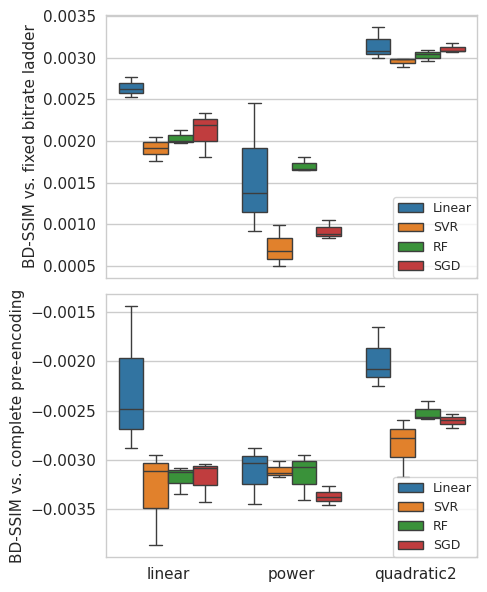

In [11]:
# 直观看一下区别
label_mapping = {
    'Adam': 'Adam',
    'LinearRegression': 'Linear',
    'LinearSVR': 'SVR',
    'RMSProp': 'RMSProp',
    'RandomForestRegressor': 'RF',
    'SGDRegressor': 'SGD'
}

# 画一下 BD-Rate (左边是相比 fixed QP 的, 右边是相比 traditional CAE 的)
fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

sns.boxplot(
    ax=axes[0], data=avg_bdbr[(avg_bdbr["bd_ssim"] > 0) & (avg_bdbr["bd_ssim"] < 0.008) & (avg_bdbr["anchor"] == "fixed") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_ssim", hue="regressor", flierprops=flierprops)
handles, labels = axes[0].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[0].set_xlabel("")
axes[0].set_ylabel("BD-SSIM vs. fixed bitrate ladder")
axes[0].legend(handles, new_labels, borderaxespad=0., loc="lower right")

sns.boxplot(ax=axes[1], data=avg_bdbr[(avg_bdbr["bd_ssim"] < 0) & (avg_bdbr["anchor"] == "cae") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_ssim", hue="regressor", flierprops=flierprops)
handles, labels = axes[1].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[1].set_xlabel("")
axes[1].set_ylabel("BD-SSIM vs. complete pre-encoding")
axes[1].legend(handles, new_labels, borderaxespad=0., loc="lower right")

fig_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"
plt.tight_layout()
plt.savefig(f"{fig_dir}/BDBR/bd_ssim.pdf", format="pdf")